# COGS 108 Meta Project - An Analysis of Previous COGS 108 Projects 

## Permissions

Place an `X` in the appropriate bracket below to specify if you would like your group's project to be made available to the public. (Note that student names will be included (but PIDs will be scraped from any groups who include their PIDs).

* [X] YES - make available
* [  ] NO - keep private

# Overview

This project looks over 364 previous COGS 108 projects over previous quarters and explores the relationship between topics, word count, table count, graph count, proejects marked by graders as special, as well as how all these variables change throughout the quarters. For example, one may expect the popularity of health related topics to increase due to COVID-19 becoming such a hot topic recently. We aimed to find out if such intuitions actually fit the data, and perhaps discover unexpected trends in the data.

# Names

- Colin Lintereur
- James Chung 
- Joonsung Park
- Madison Hambly
- Richard Gross

<a id='research_question'></a>
# Research Question

How do the most popular topics from previous COGS 108 final projects vary per quarter from 2019 to 2021? Also what other trends can we find in past submissions, like changes in word count, and number of graphs used?

<a id='background'></a>

## Background & Prior Work

While looking through the previous COGS 108 final projects for our project review, we noticed that the main COGS108 repository contains a lot of final project submission from previous quarters [1]. During the process for looking through the previous submissions, we thought that there might have been an increase of projects related to certain topics, like COVID. Because of this, we thought it would be interesting to use those submissions as our dataset and to quantify the popularity of the topics of those previous projects and how popular topics for projects changed over time. In order to be able to use the previous submissions, we looked into how we could parse the notebook files so that we could easily extract whatever we needed from them since the structure of notebook files is strange [2]. Understanding this methodology would be essential to deciding the approach that we will take to acquire and eventually wrangle the topic data that we seek to analyze. 

References (include links):
- 1) https://github.com/orgs/COGS108/repositories?page=1
- 2) https://towardsdatascience.com/notebook-meta-analysis-jupyter-as-a-zero-infrastructure-alternative-to-experiment-trackers-69e7343d1343?gi=b945c70dda05

# Hypothesis


We predict that projects related to public health and politics will be more popular and we think that popular topics do not vary too much per quarter. Due to most of the submissions between 2019 and 2021 being submitted during COVID and periods of social unrest, we suspect that it would have been a very popular to run data analysis on topics related to these events. We also expect that whatever topics were popular in one quarter, were still popular in subsequent quarters since quarters are a relatively short amount of time and it would be unlikely that popular project topics would change drastically during that time.

# Dataset(s)

- Dataset Name: Past COGS108 final projects
- Links to the datasets: 
    - [https://github.com/COGS108/FinalProjects-Sp21](https://github.com/COGS108/FinalProjects-Sp21)
    - [https://github.com/COGS108/FinalProjects-Wi21](https://github.com/COGS108/FinalProjects-Wi21)
    - [https://github.com/COGS108/FinalProjects-Fa20](https://github.com/COGS108/FinalProjects-Fa20)
    - [https://github.com/COGS108/FinalProjects-Sp19](https://github.com/COGS108/FinalProjects-Sp19)
    - [https://github.com/COGS108/FinalProjects-Sp20](https://github.com/COGS108/FinalProjects-Sp20)
    - [https://github.com/COGS108/FinalProjects-Wi20](https://github.com/COGS108/FinalProjects-Wi20)
- Number of observations: 364

We looked through the COGS108 github repositories and downloaded the zip file for each quarter of submissions we wanted to include in our analyis. From there, we process each jupyter notebook in the zip file and collect relevant data, parsing it to find the research question of the group. We then generate a csv file for each quarter, and once we have all the csv files of each quarter, we combine them into one final dataset we want to study. There are more quarters and submissions that are not yet included but we may include more if necessary.

# Setup

In [22]:
# importing libraries
import numpy as np
import json
import re
import requests
import pandas as pd
import glob
import seaborn as sns
import zipfile
sns.set(font_scale=1, style="white")

# import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
from matplotlib.cbook import boxplot_stats

plt.rcParams['figure.figsize'] = (20, 10)

# Statmodels & patsy
import patsy
import statsmodels.api as sm

# using glob to get all csvs
files = glob.glob('./csvs/*.csv')
df = pd.DataFrame()
entries = 0

# read all csvs to dataframes and combine into one df
for f_name in files:
    csv = pd.read_csv(f_name)
    df = df.append(csv)
    entries = entries + len(csv.index)

assert(len(df.index) == entries)
print('Observations: ' + str(len(df.index)))
df.head()

# copy/paste API key for uClassify
API_KEY = 'pUllRXrepgLH'

Observations: 364


We now search through the zip file of a quarter we want to study. We can get the quarter/group/year information from the file names. We get the research question by looking for the "Research Question" (or some similar) header and getting the text after it.

We manually ran this code for each project repo/zip. 

In [17]:
# initializing lists
research_questions = {}
qtr = []
year = []
group = []
# special projects are marked with '_S' at the end of its name
special = []
word_counts = []
graph_counts = []
table_counts = []
index = 0

# a magic number to guess if this string is the research question
# (minimum character length)
MIN_RQ_LEN = 30

# reading zip file for a certain quarter
with zipfile.ZipFile("zips/FinalProjects-Wi21-main.zip", "r") as f:
    for i, name in enumerate(f.namelist()):
        # skip files that are not jupyter notebooks
        if '.ipynb' not in name:
            continue
        rf = json.loads(f.read(name))
        word_count = 0
        graph_count = 0
        table_count = 0
        rq_found = False
        rq_in_header = False
        
        # loop through every cell
        for j, cell in enumerate(rf['cells']):
            if cell['cell_type'] == 'code':
                if ('outputs' in cell) and (cell['outputs'] != []):# and ('data' in cell['outputs'][0]):# and ('image/png' in cell['outputs'][0]['data'])
                    for k,_ in enumerate(cell['outputs']):
                        if 'data' in cell['outputs'][k]:
                            if 'image/png' in cell['outputs'][k]['data']:
                                graph_count += 1
                            if 'text/html' in cell['outputs'][k]['data']:
                                table_count += 1
            elif cell['cell_type'] == 'markdown':
                # for the cell with the rq header, source_len > 1
                # means the question is also in this cell
                source_len = len(cell['source'])
                for c in cell['source']:
                    # if cell contains the research question header, update lists and extract the research question from the next cell
                    if (rq_found == False) and (rq_in_header == True or re.search(r"(^#.*research question)", c.lower()) != None):
                        # some other string in the cell's source list should be the question
                        if source_len > 1 and rq_in_header == False:
                            rq_in_header = True
                            continue

                        # if there is more text after the header, question may be in THIS cell
                        if rq_in_header == True:
                            # ignore '\n' string or any string that is probably not the rq
                            if len(c.lstrip()) < MIN_RQ_LEN:
                                continue
                            rq = str(c)
                            rq_in_header = False
                        # get the research question from the cell AFTER the cell that contains the header 'Research Question'
                        else:
                            rq = ' '.join(rf['cells'][j+1]['source'])
                        # remove pesky html tags for API to handle correctly
                        rq = re.sub('<[^<]+?>', '', rq)
                        
                        # extract quarter info from repo name
                        date = re.search(r"-(.*)-", name).group(1)
                        qtr.append(date[:2].upper())
                        year.append(int(date[2:]))

                        # extract group number
                        fname = re.search(r"/.*", name).group(0)
                        group.append(int(re.search(r"[$0-9^]{2,3}", fname)[0]))

                        special.append(False if re.search(r"_S\.ipynb", name) == None else True)
                        
                        research_questions[str(group[index])+"_"+qtr[index]+"_"+str(year[index])] = rq          
                        rq_found = True
                        index += 1
                    word_count += len(c.replace('#', '').lstrip().split(' '))
        if rq_found:
            word_counts.append(word_count)
            graph_counts.append(graph_count)
            table_counts.append(table_count)

After collecting all the data we need from the submissions, we can use a text classifier to find the general topic of the submission. We are currently using an API made by uClassify to do this classification for us. See [here](https://www.uclassify.com/browse/uclassify/iab-taxonomy-v2?input=Text) for details on the API we are using.

In [10]:
# initialize topics list
topic = []

# loop through research questions and find the most confident topic class from topic classifier
for i, (g, q, y) in enumerate(zip(group, qtr, year)):
    text = research_questions[str(group[i])+"_"+qtr[i]+"_"+str(year[i])]

    # conform to latin-1 encoding for API
    text = text.encode('latin-1', 'replace').decode('latin-1')
    # don't allow literal quotes and remove unknown symbols
    text = text.replace('\"', '').replace('?', '')
    
    # get the Response object
    response = requests.post('https://api.uclassify.com/v1/uclassify/iab-taxonomy-v2/classify',
        data = "{\"texts\":[\"" + text + "\"]}",
        headers = {'Authorization': 'Token ' + API_KEY})

    closest_topic = ''
    max_p = 0
    # find the highest predicted topic
    for t in response.json()[0]['classification']:
        if t['p'] > max_p:
            closest_topic = t['className']
            max_p = t['p']
    topic.append(closest_topic.split('_')[0])
    if i == 0:
        print("EXAMPLE:\n", research_questions[str(group[i])+"_"+qtr[i]+"_"+str(year[i])], " :: ", topic[i])

EXAMPLE:
 *What is the relative effect of unemployment, poverty, and homelessness on adult obesity rates (BMI >= 30) across states in the United States?*  ::  business and finance


Now that we have stored the topics of the submissions, we can run a sanity check to make sure that all of our list are the same length and then export the data to a csv file.

In [18]:
# double check that all the lists are the same length
print(len(group), len(qtr), len(year), len(topic), len(special), len(word_counts), len(graph_counts), len(table_counts))

# generate data frame and output it to a csv file
d = {'Group':group, 'Quarter':qtr, 'Year':year, 'Topic':topic, 'Special':special, 'Word_Count':word_counts, 'Graph_Count':graph_counts, 'Table_Count':table_counts}
df = pd.DataFrame(data = d)
output = df.to_csv(path_or_buf="./csvs/"+qtr[0] + "20" + str(year[0])+".csv", index=False)

65 65 65 65 65 65 65 65


# Data Cleaning

Since we are collecting the data ourselves, there is not much work to be done cleaning the data after collecting all of the csv files for each quarter and merging them together into one large dataset. One operation we will perform, however, is generating a "Quarter_Index" so that we can analyze our data in chronological order based on the quarter. We generate a dictionary called `qtr_index_dict` which will generate an index for each quarter from Spring 19 to Spring 21. 

*NOTE, we do not have any data for Fall 2019 so this quarter is skipped when indexing.*

In [23]:
# using glob to get all csvs
files = glob.glob('./csvs/*.csv')
df = pd.DataFrame()
entries = 0

# read all csvs to dataframes and combine into one df
for f_name in files:
    csv = pd.read_csv(f_name)
    df = df.append(csv)
    entries = entries + len(csv.index)

assert(len(df.index) == entries)
print('Observations: ' + str(len(df.index)))

#Add chronological order to rows
chronological = []
#starting from spring 19 as 0
#NOTE: We do not have any data for Fall 2019
qtr_index_dict = {"SP19": 0, "WI20": 1, "SP20": 2, "FA20": 3, "WI21": 4, "SP21": 5}
qtr_index = []

for index, row in df.iterrows():
#     print(row['Quarter'], row['Year'])
    qtr = row['Quarter'] + str(row['Year'])
    qtr_index.append(qtr_index_dict[qtr])
df['Quarter_Index'] = qtr_index

df.head()

Observations: 364


,Group,Quarter,Year,Topic,Special,Word_Count,Graph_Count,Table_Count,Quarter_Index
0,1,FA,20,music and audio,False,6999,15,2,3
1,2,FA,20,automotive,False,8686,18,16,3
2,4,FA,20,video gaming,False,1864,13,5,3
3,5,FA,20,sports,False,5483,32,18,3
4,6,FA,20,pets,False,4595,19,7,3


# Data Analysis & Results

First we see how much data we have from each quarter to see if there are any quarters with a lot of projects which may bias our analysis.

<AxesSubplot:xlabel='Quarter_Index', ylabel='count'>

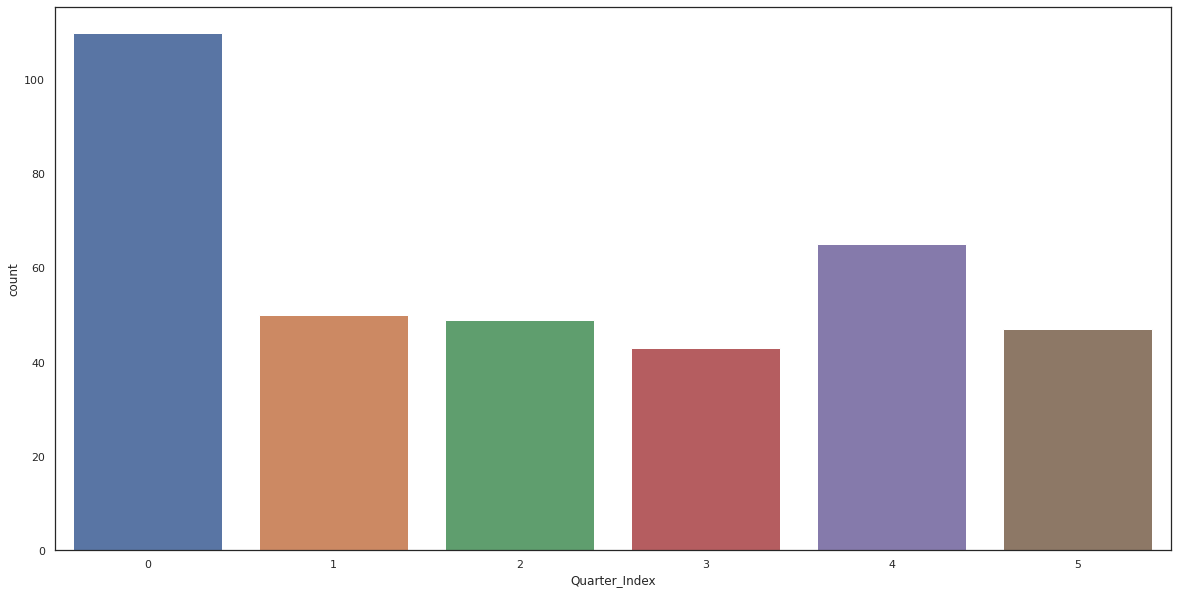

In [24]:
sns.countplot(x='Quarter_Index',data=df)

We can see that our first quarter, Spring 2019, has a much larger number of projects in our datasets than the other quarters. This means that any topics in vogue during that quarter will be disproportionately represented in our data, which will need to be taken into account during analysis.

Next, we counted the total amount of each topic we classified. The overarching topic of each project was found through a topic determining API reading the initial research proposal at the start of each project.

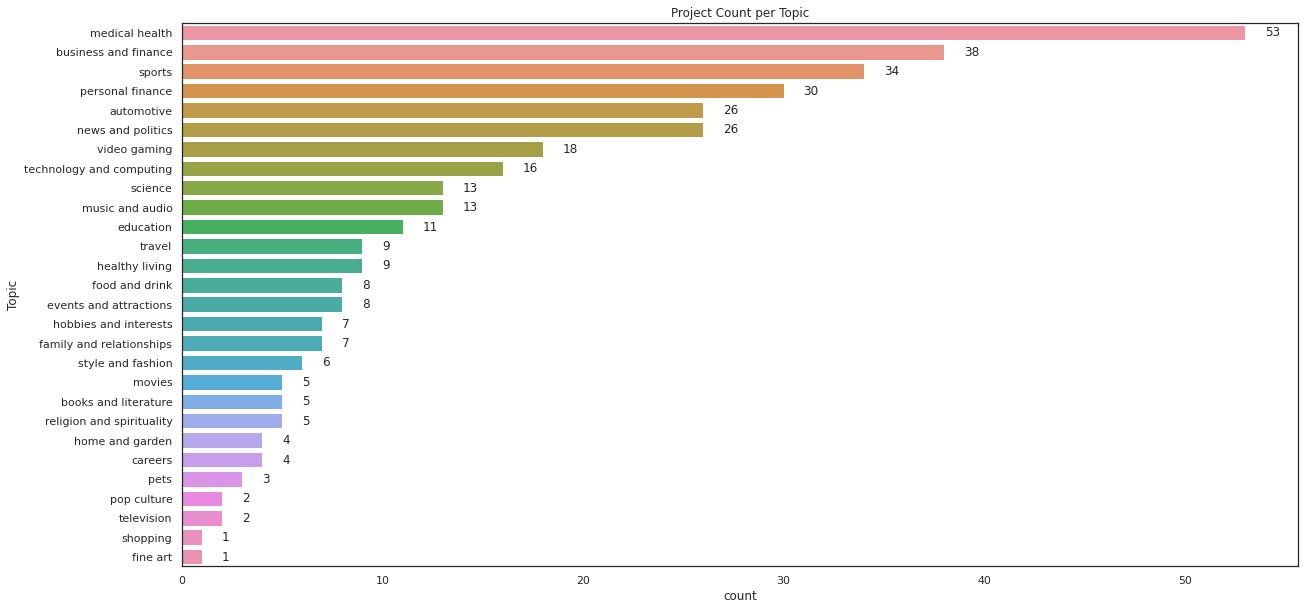

In [14]:
#Total amount of each topic
topic_count = sns.countplot(y='Topic',data=df, order=df['Topic'].value_counts().index)
topic_count.set(title='Project Count per Topic') # title barplot
# label each bar in barplot
for p in topic_count.patches:
    height = p.get_height() # height of each horizontal bar is the same
    width = p.get_width() # width (average number of passengers)
    #adding text to each bar
    topic_count.text(x = width+1, # x-coordinate position of data label, padded 1 to right of bar
    y = p.get_y()+(height/2), # # y-coordinate position of data label, padded to be in the middle of the bar
    s = '{:.0f}'.format(width), # data label, formatted to ignore decimals
    va = 'center') # sets vertical alignment (va) to center"

We can see that medical health is very popular as research topics which is not too surprising given these quarters were all impacted by COVID. However, even if we ignore the popularity of health related topics, we can see that certain topics are much more popular than others, such as finance and sports over pets and pop culture, as opposed to a uniform distribution of topics.

Next, we measured the word count, graph count, and table count per quarter. 

<AxesSubplot:xlabel='Quarter_Index', ylabel='Word_Count'>

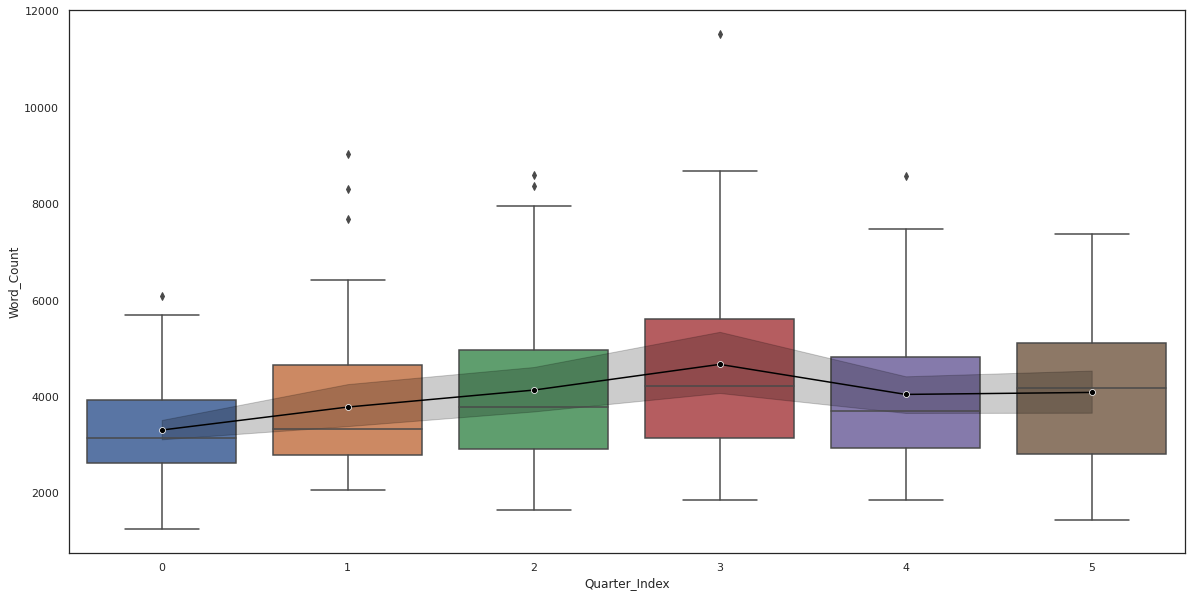

In [5]:
sns.boxplot(x='Quarter_Index', y='Word_Count', data=df)
sns.lineplot(x='Quarter_Index', y='Word_Count', data=df, marker="o" ,color ='black')

This graph compares word count per quarter. Interestingly, even though the first quarter on the left, Spring 2019, had double the projects, it has the smallest word count. The word count mean also increases by quarter until Fall 2020 (3), and evens out of at winter 2021 (4)

<AxesSubplot:xlabel='Quarter_Index', ylabel='Graph_Count'>

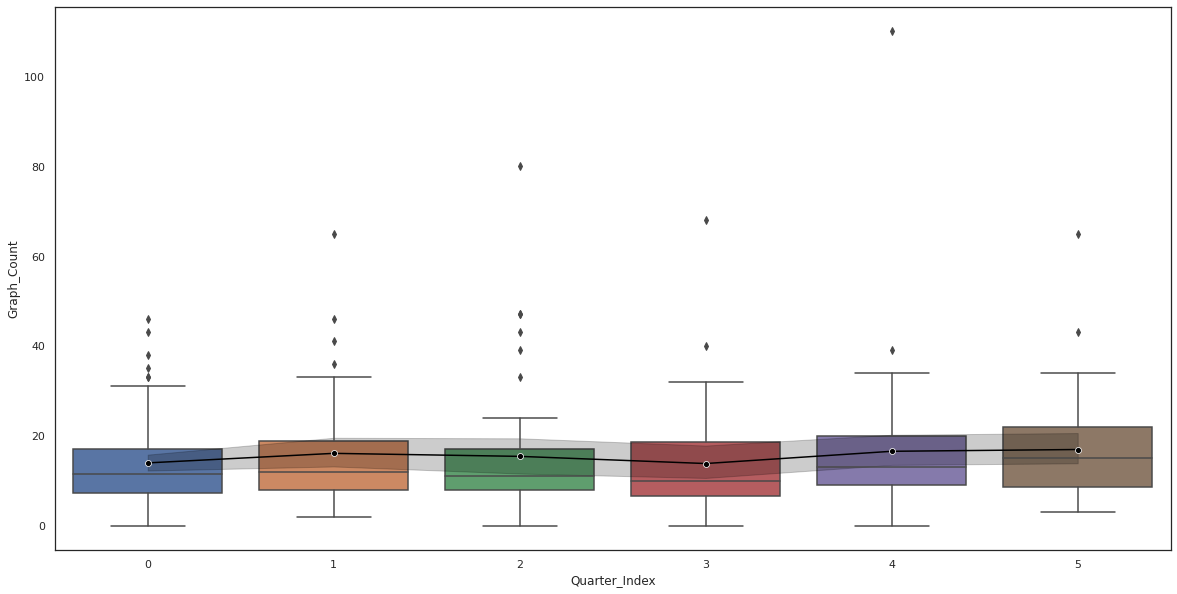

In [25]:
sns.boxplot(x='Quarter_Index', y='Graph_Count', data=df)
sns.lineplot(x='Quarter_Index', y='Graph_Count', data=df, marker="o" ,color ='black')

This graph compares the amount of images/graphs per quarter. There appears to be no significant trend, with most projects being somewhere between 10 to 20 graphs. Though the single outlier with over 100 graphs in Winter 2021 is impressive.

<AxesSubplot:xlabel='Quarter_Index', ylabel='Table_Count'>

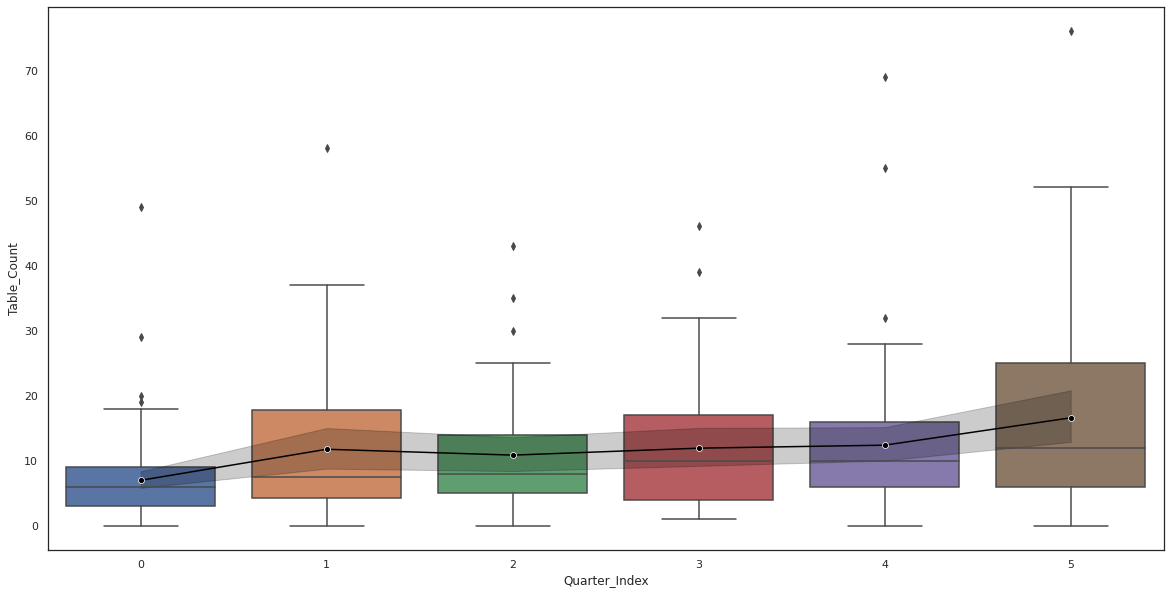

In [26]:
sns.boxplot(x='Quarter_Index', y='Table_Count', data=df)
sns.lineplot(x='Quarter_Index', y='Table_Count', data=df, marker="o" ,color ='black')

This graph compares the amount of data tables that appear in the project by quarter. Interestingly, there appears to be a clear upward trend when looking at the means (the middle line of the box plots).

Next, we measured the word count, graph count, and table count per topic.

<AxesSubplot:xlabel='Word_Count', ylabel='Topic'>

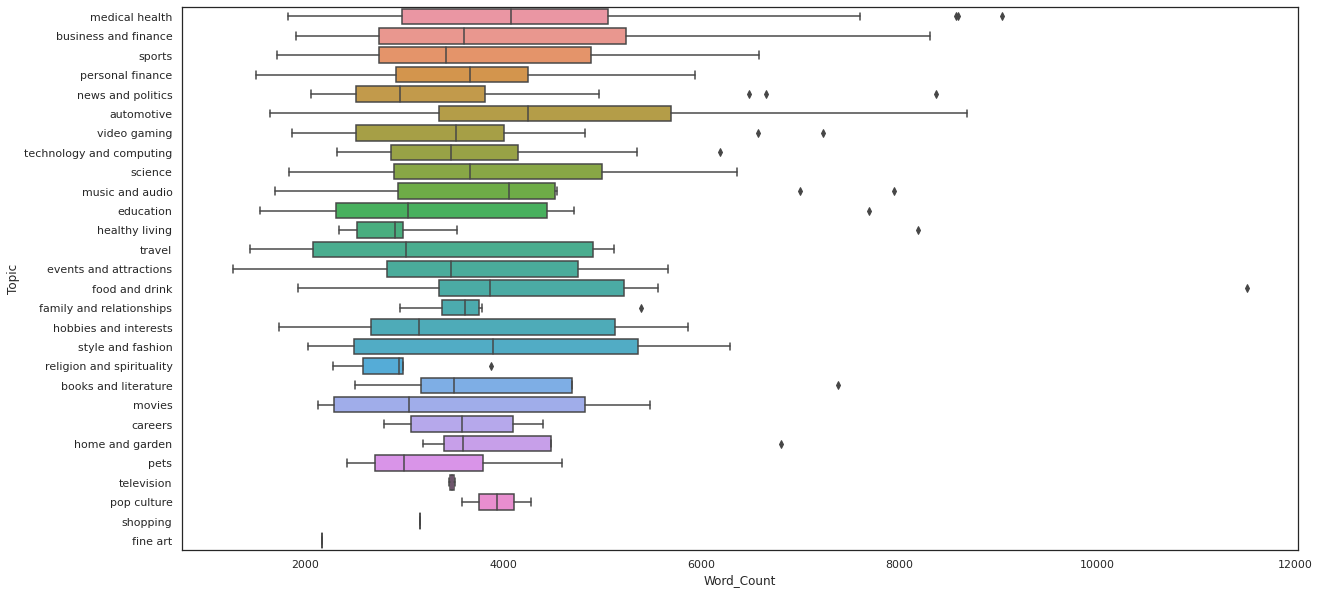

In [8]:
#wordcount boxplot per topic, ordered by topic popularity
sns.boxplot(y='Topic', x='Word_Count', data=df, order=df['Topic'].value_counts().index)

In terms of word count, it seems that the popularity of a topic does not have much an impact. We can see that more popular topics, which are higher up on the boxplots,have longer whiskers but this is most likely caused by higher variability in topics that are more popular since there are more papers for those topics.

<AxesSubplot:xlabel='Graph_Count', ylabel='Topic'>

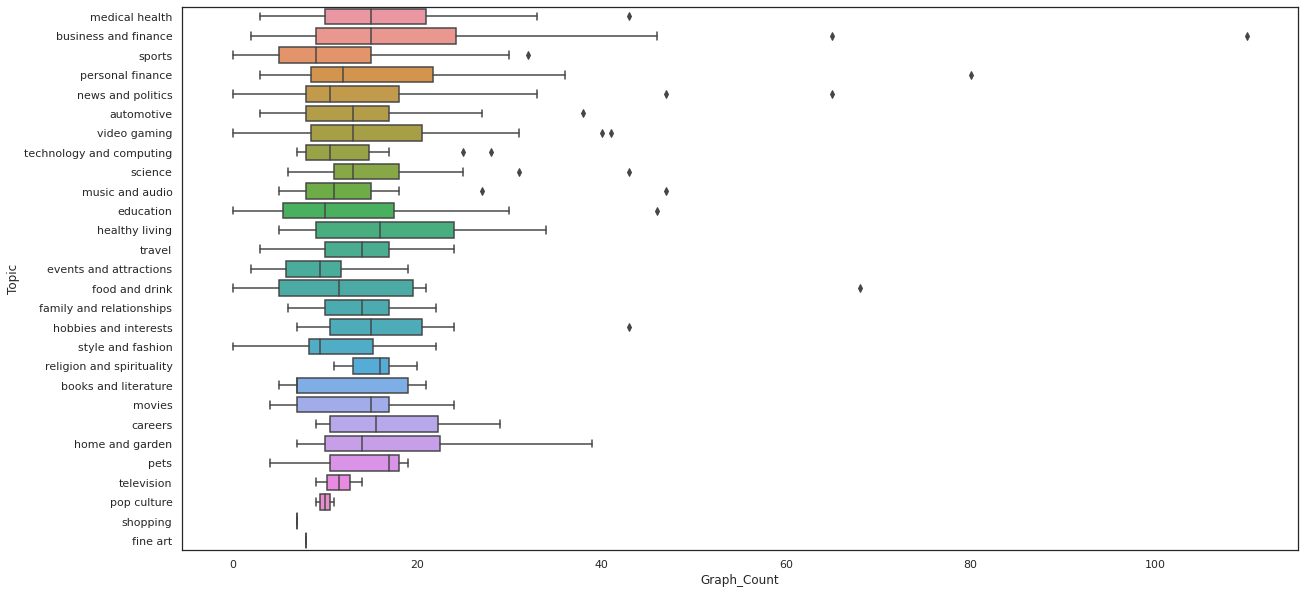

In [9]:
#graphcount boxplot per topic, ordered by topic popularity
sns.boxplot(y='Topic', x='Graph_Count', data=df, order=df['Topic'].value_counts().index)

In term of graph count, there is not much impact based on the popularity of the topic.

<AxesSubplot:xlabel='Table_Count', ylabel='Topic'>

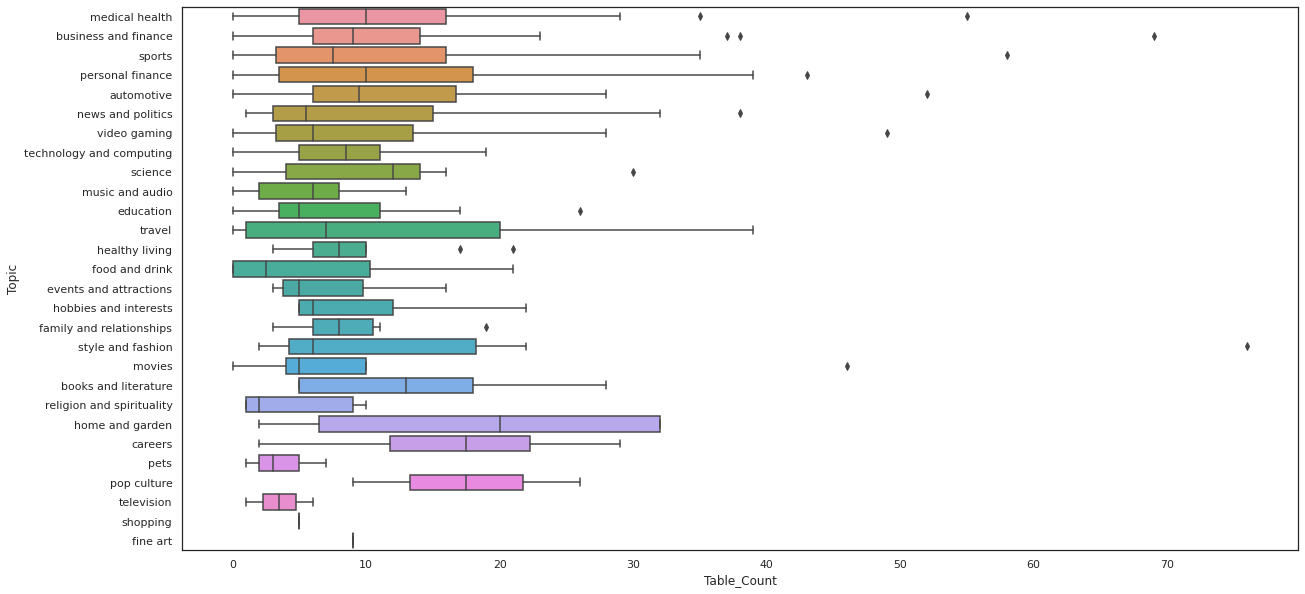

In [25]:
#tablecount boxplot per topic, ordered by topic popularity
sns.boxplot(y='Topic', x='Table_Count', data=df, order=df['Topic'].value_counts().index)

With table count, we can see that less popular topics tend to have higher amounts of tables. 

Next, we graphed the counts of the top 10 most popular topics throughout each quarter using our quarter index. 

<AxesSubplot:xlabel='Topic', ylabel='count'>

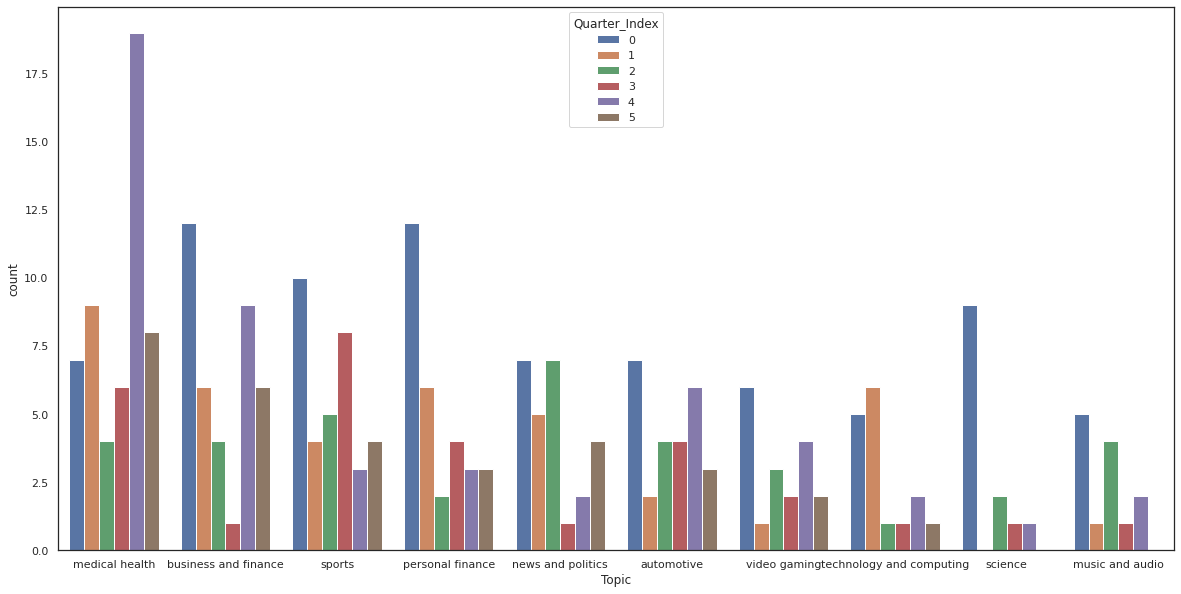

In [11]:
sns.countplot(x='Topic',data=df, hue='Quarter_Index', order=df['Topic'].value_counts().index[:10])

Most topic distributions seem fairly uniform but one notable outlier is 'medical health' in Winter 2021 (4) which had a significant number of papers on that topic.

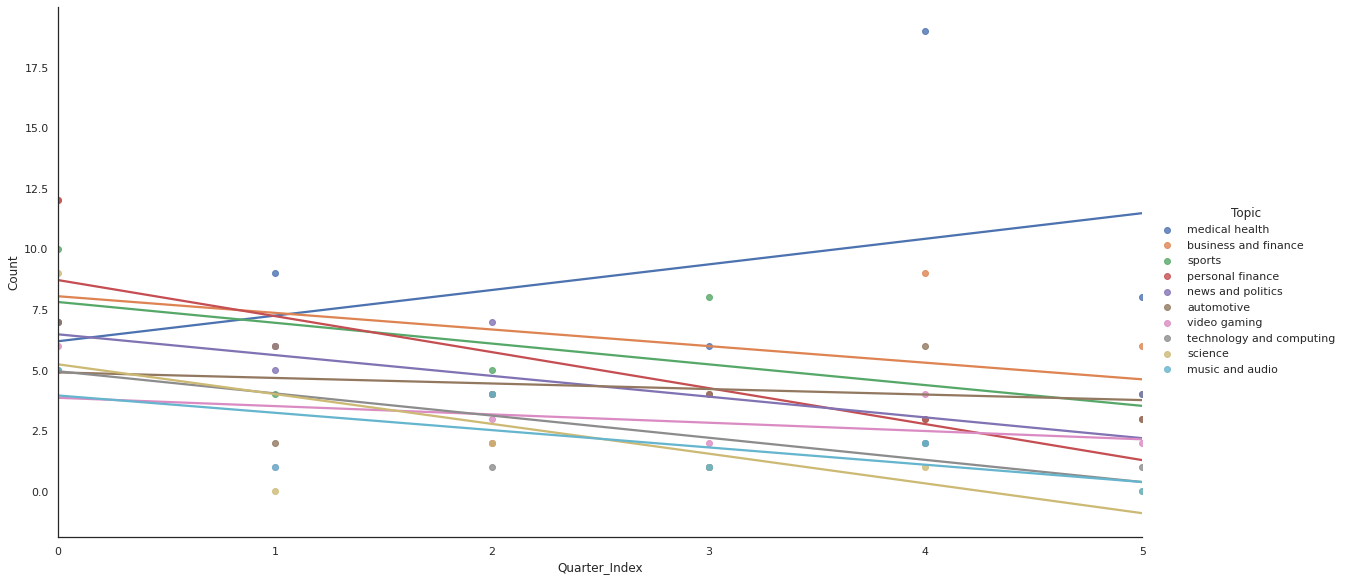

In [59]:
topics = []
indices = []
counts = []

for topic in df['Topic'].value_counts().index[:10]:
    for i in range(6):
        topics.append(topic)
        indices.append(i)
        counts.append(len(df[(df['Topic'] == topic) & (df['Quarter_Index'] == i)]))
        
tempDf = pd.DataFrame()
tempDf['Topic'] = topics
tempDf['Quarter_Index'] = indices
tempDf['Count'] = counts
sns.lmplot(x='Quarter_Index',data=tempDf, hue='Topic', y='Count', height=8, aspect=2, ci=None)

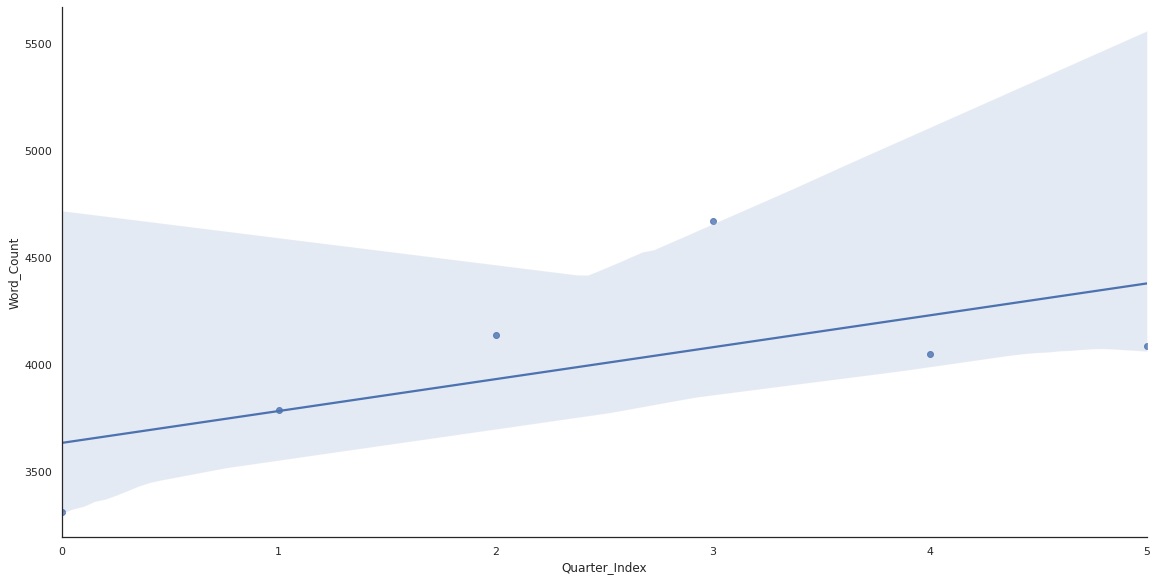

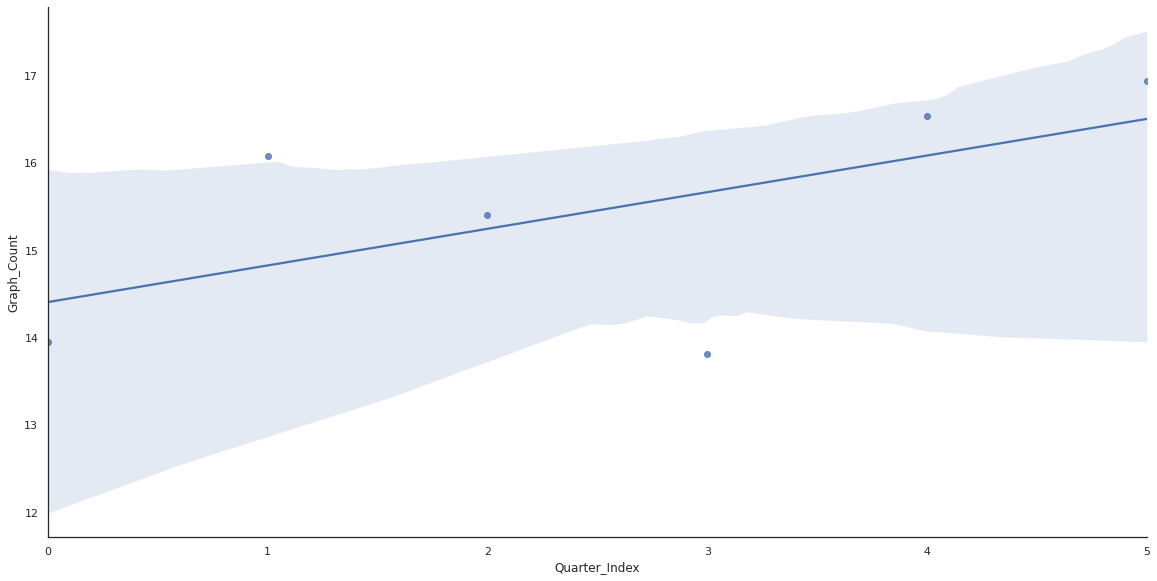

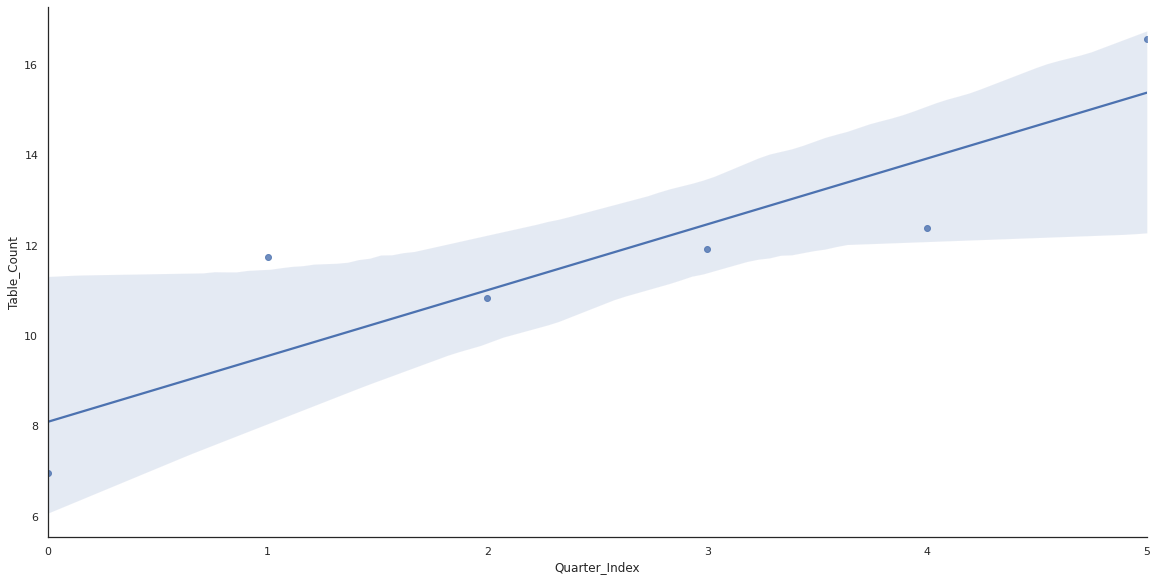

In [42]:
w_counts = []
g_counts = []
t_counts = []
indices = []

for i in range(6):
    indices.append(i)
    w_counts.append(0)
    g_counts.append(0)
    t_counts.append(0)
    w_counts[i] += sum(df[df['Quarter_Index'] == i]['Word_Count']) / len(df[df['Quarter_Index'] == i]['Word_Count'])
    g_counts[i] += sum(df[df['Quarter_Index'] == i]['Graph_Count']) / len(df[df['Quarter_Index'] == i]['Graph_Count'])
    t_counts[i] += sum(df[df['Quarter_Index'] == i]['Table_Count']) / len(df[df['Quarter_Index'] == i]['Table_Count'])
        
tempDf = pd.DataFrame()
tempDf['Quarter_Index'] = indices
tempDf['Word_Count'] = w_counts
tempDf['Graph_Count'] = g_counts
tempDf['Table_Count'] = t_counts

sns.lmplot(x='Quarter_Index',data=tempDf, y='Word_Count', height=8, aspect=2)#, ci=None)
sns.lmplot(x='Quarter_Index',data=tempDf, y='Graph_Count', height=8, aspect=2)#, ci=None)
sns.lmplot(x='Quarter_Index',data=tempDf, y='Table_Count', height=8, aspect=2)#, ci=None)

Most topic distributions seem fairly uniform but one notable outlier is 'medical health' in Winter 2021 which had a significant number of papers on that topic.

Next, we wanted to compare the popularity of different project topics within the projects that the instructional staff flagged as being "particularly strong and impressive" (denoted as "special"). 

Text(0.5, 1.0, 'The Five Most Popular Topics Among Projects Denoted as "Special"')

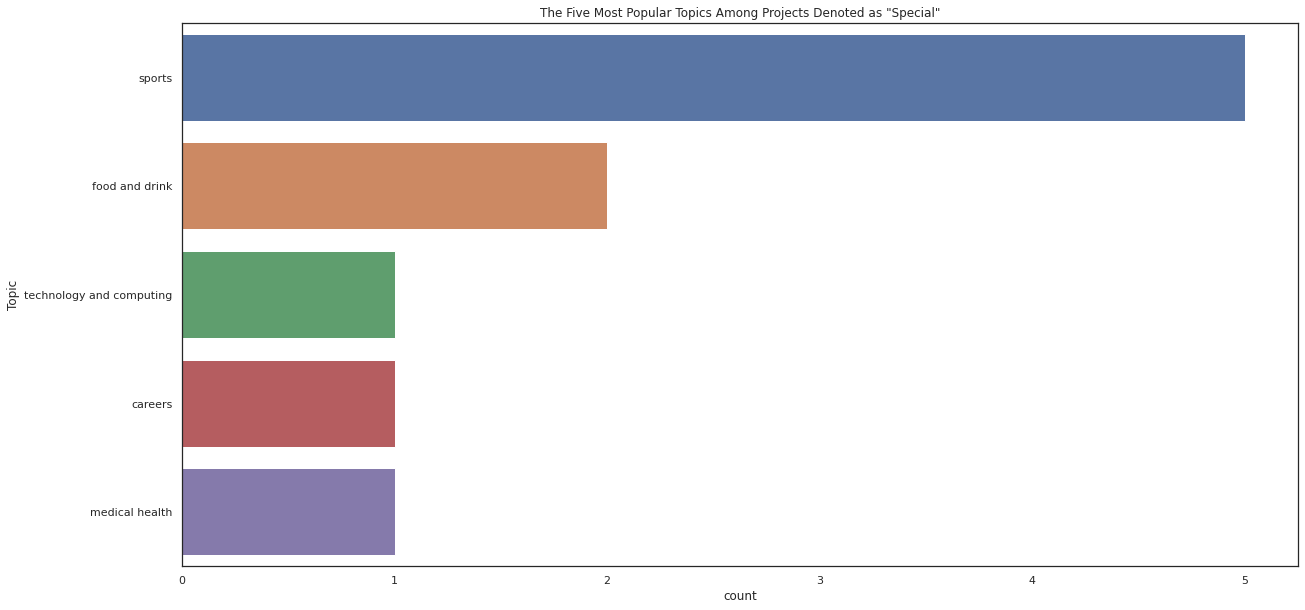

In [13]:
special_df = df.loc[df.Special == True]

special_df.head()

top_special = special_df['Topic'].value_counts()[:5].index.tolist()

top_special_df = special_df[special_df.Topic.isin(top_special)]

top_special_df = top_special_df.reset_index(drop = True)

sns.countplot(y=top_special_df['Topic'], order = top_special_df['Topic'].value_counts().index).set_title('The Five Most Popular Topics Among Projects Denoted as "Special"')


As seen in the bar plot above, the most popular topic category within these special projects was "Sports" by a large margin (five projects out of the total seventeen). The "Food and Drink" category was the second most popular category among the special projects (two out of the seventeen). All other categories listed only had one special project in each. Despite the massive amount of health related projects, not a single one was marked as impressive.

Finally, we took a look at the proportion of projects that were flagged as "special" by the COGS 108 instructional team in each quarter. 

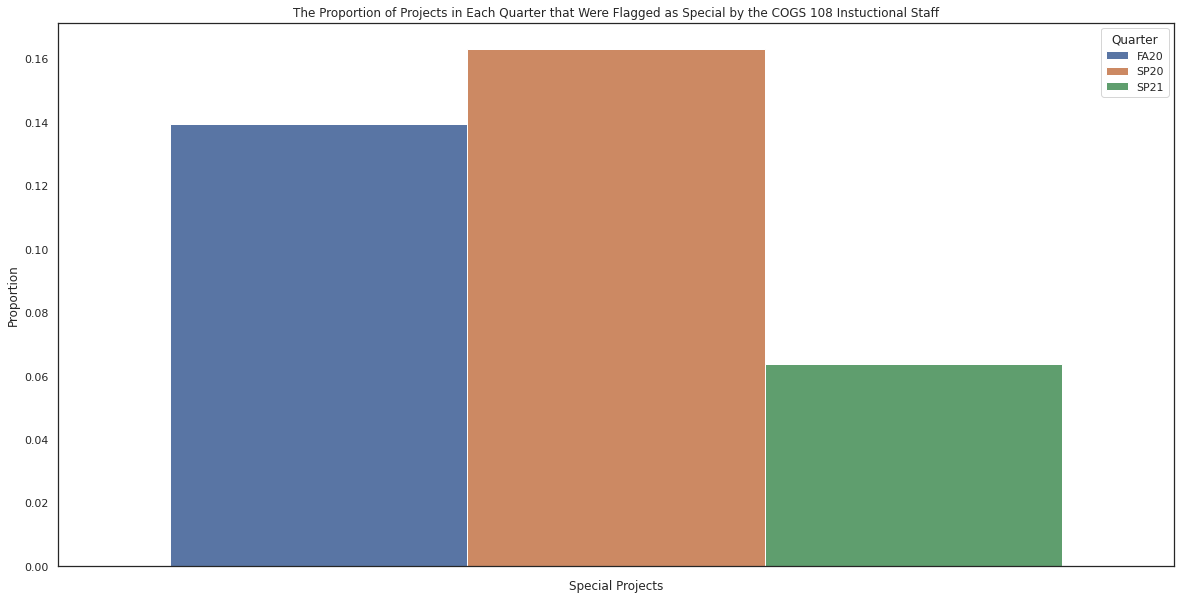

In [14]:
yr_qtr = (df.Quarter).str.cat(df.Year.astype(str))
df_yr_qtr = df

df_yr_qtr = df_yr_qtr.drop(columns = ['Quarter'])


df_yr_qtr['Quarter'] = yr_qtr


yr_qtr_groups = df_yr_qtr.groupby('Quarter')
prop_special = yr_qtr_groups['Special'].value_counts(normalize = True).rename('Proportion')
prop_df = prop_special.to_frame().reset_index()

prop_special_df = prop_df.loc[prop_df['Special'] == True]


prop_plot = sns.barplot(x = 'Special', y = 'Proportion', hue = 'Quarter', data = prop_special_df).set(xticklabels = [], title = ('The Proportion of Projects in Each Quarter that Were Flagged as Special by the COGS 108 Instuctional Staff'), xlabel = ('Special Projects'))


Interestingly, none of the projects in the Spring 2019, Winter 2020 or Winter 2021 quarters were given the distinction of being "special". Approximately 16% of projects from Spring 2020 were flagged as special, the largest proportion among all of the quarters.

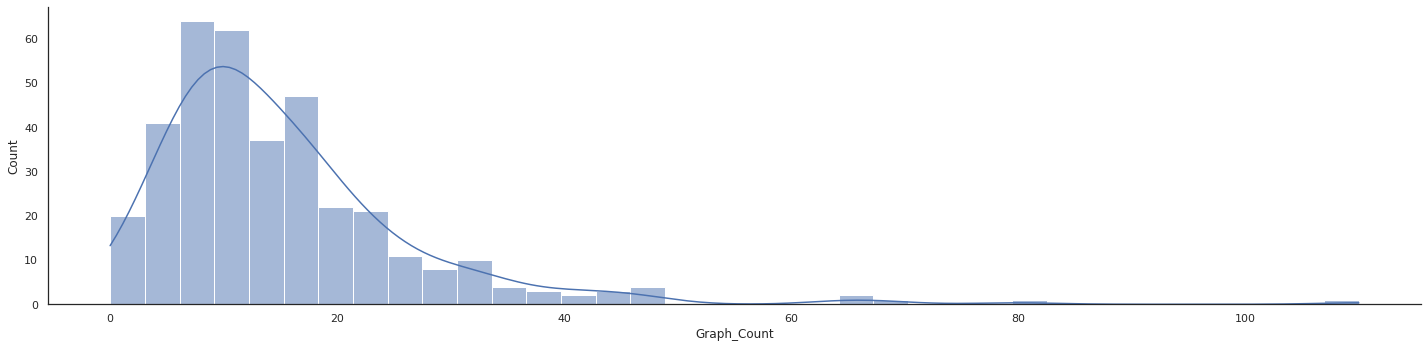

In [15]:
distribution_graph = sns.displot(df['Graph_Count'],kde=True,height=5,aspect=4)

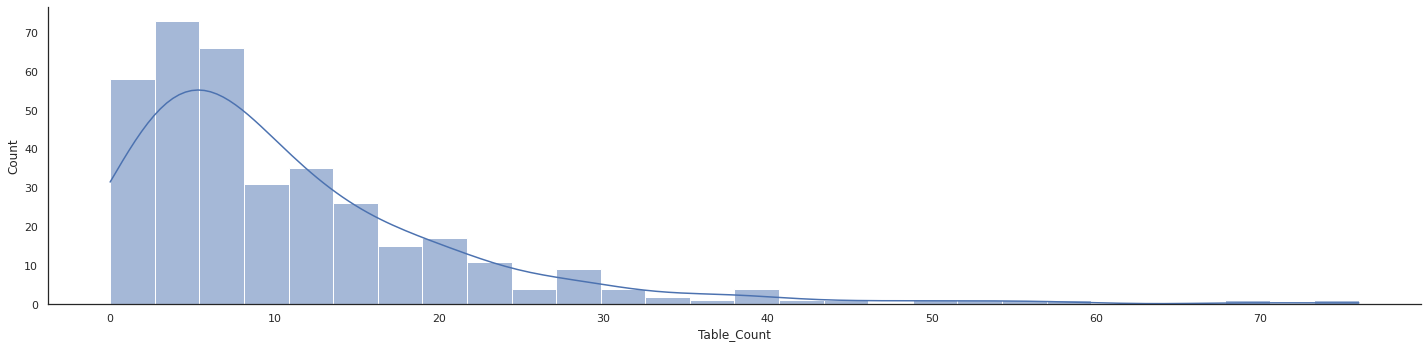

In [16]:
distribution_graph = sns.displot(df['Table_Count'],kde=True,height=5,aspect=4)

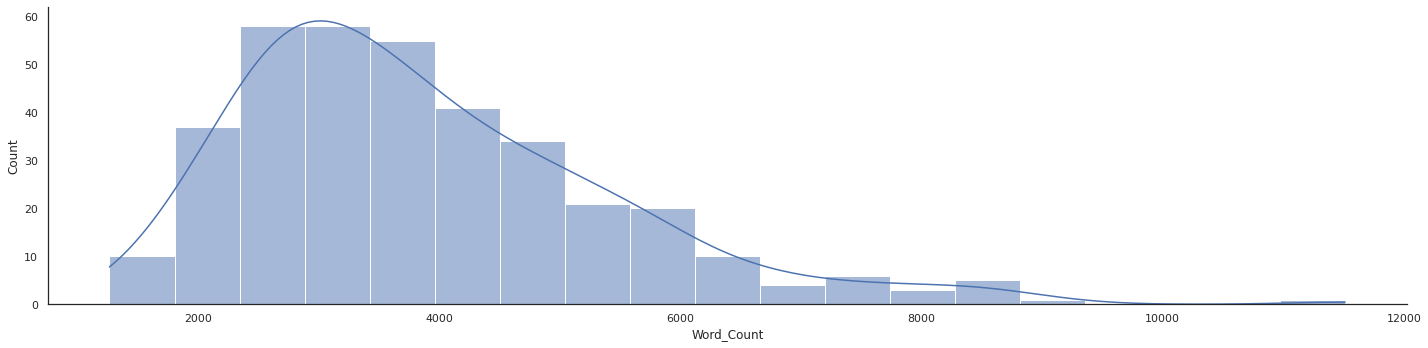

In [17]:
distribution_graph = sns.displot(df['Word_Count'],kde=True,height=5,aspect=4)

The distribution graphs show that the projects Word/Graph/Table count is positively skewed. (This is due to no limitation nor specific requirement for Word/Graph/Table which few groups did mroe than enough to analyze their data.)

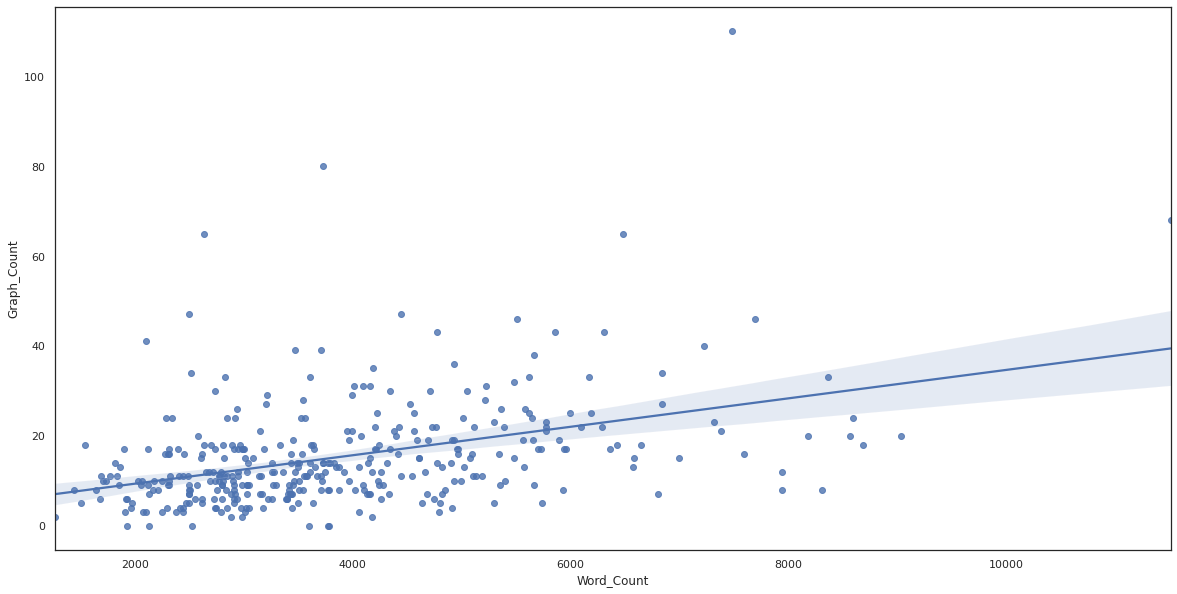

In [18]:
regression_graph= sns.regplot(x='Word_Count',y='Graph_Count',data=df)

As regression line shown above, upward regression line indicate that the number of words students use to analyze their projects increase when the number of graphs increase.

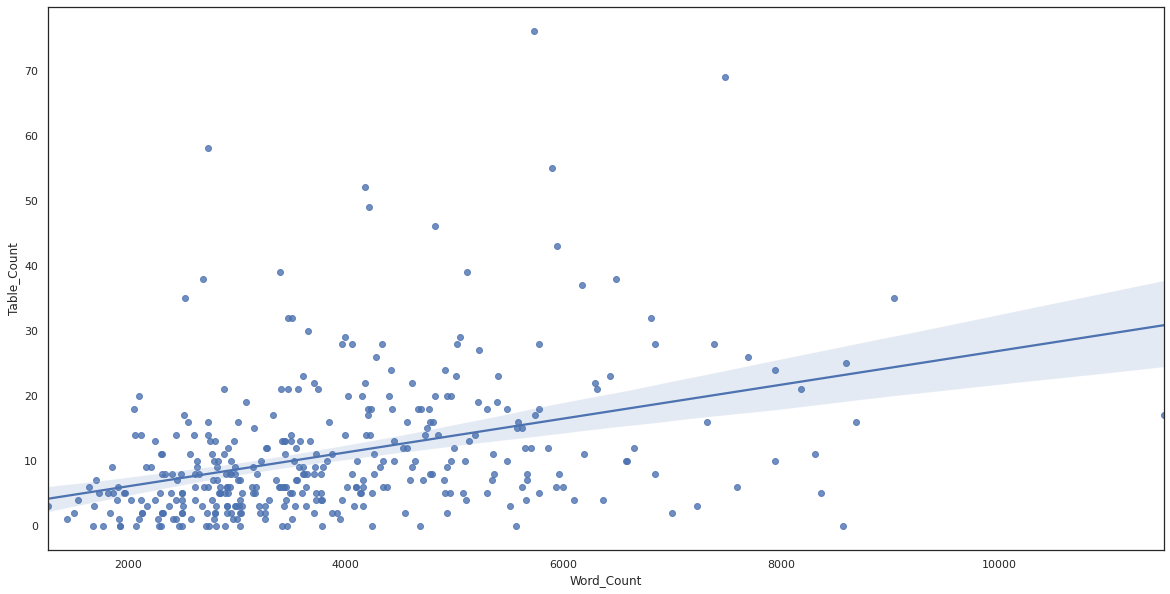

In [19]:
regression_graph= sns.regplot(x='Word_Count',y='Table_Count',data=df)

Table also show similar trend of more table is related to more words.

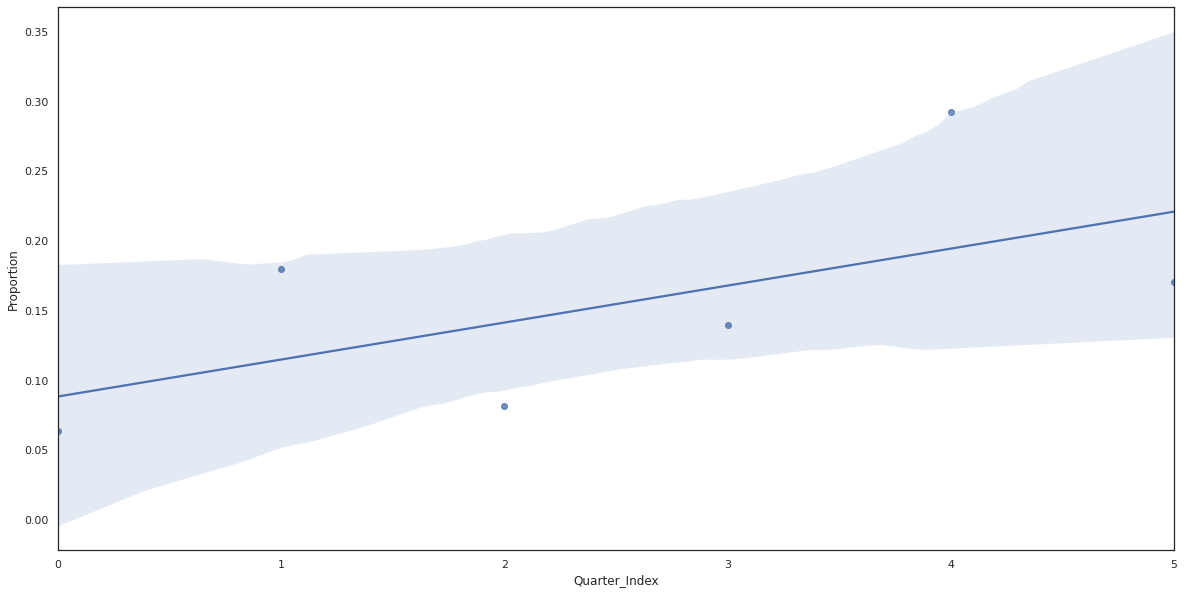

In [20]:
# time and the proportion of topics pertaining to medical health

yr_qtr_index_groups = df.groupby('Quarter_Index')
prop_topic_2 = yr_qtr_index_groups['Topic'].value_counts(normalize = True).rename('Proportion')
prop_topic_2 = prop_topic_2.to_frame().reset_index()

prop_topic_2 = prop_topic_2[prop_topic_2['Topic'] == 'medical health']

regression_graph= sns.regplot(x='Quarter_Index', y='Proportion', data = prop_topic_2)

<AxesSubplot:xlabel='Topic', ylabel='Word_Count'>

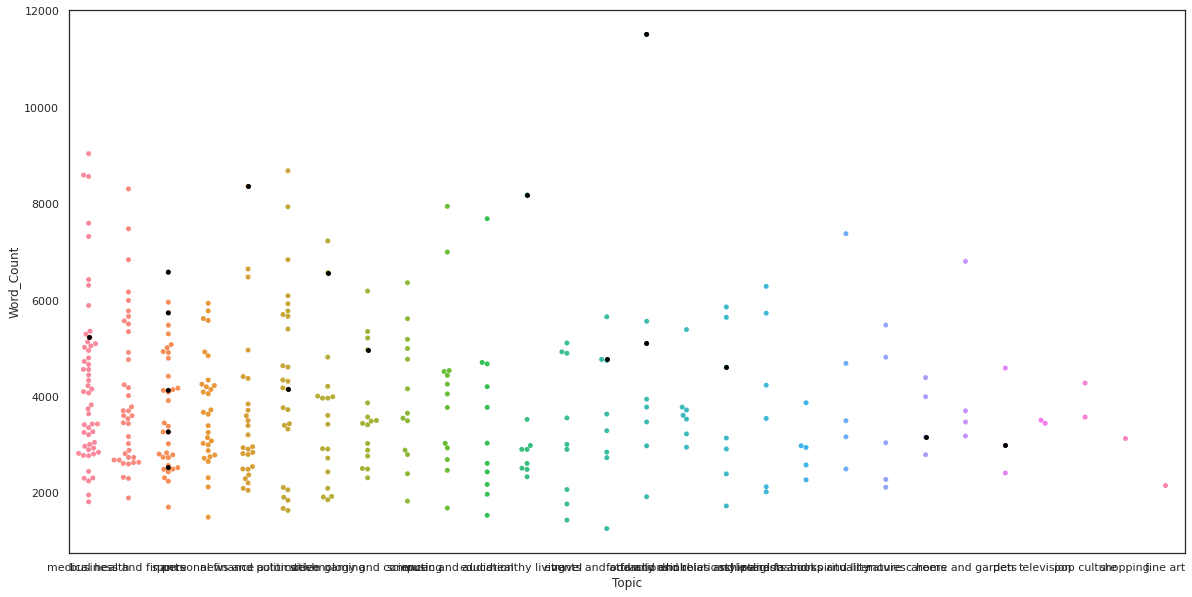

In [22]:
sns.swarmplot(x='Topic', y='Word_Count', data=df, order=df['Topic'].value_counts().index)
sns.swarmplot(x='Topic', y='Word_Count', data=df[df['Special']==True], order=df['Topic'].value_counts().index, color='black')

<AxesSubplot:xlabel='Topic', ylabel='Table_Count'>

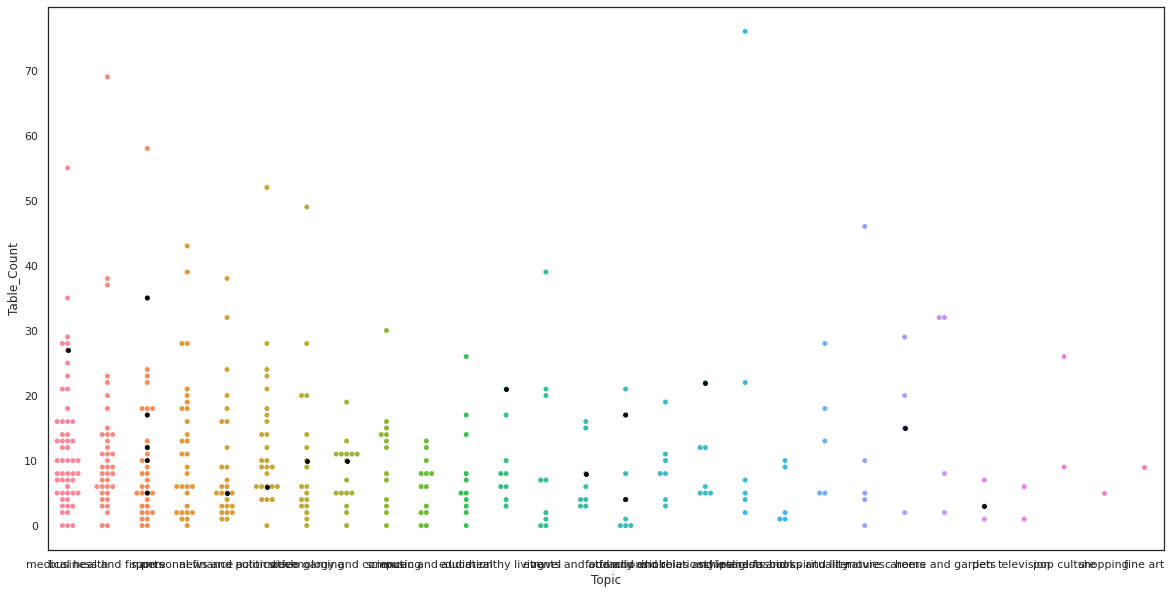

In [23]:
sns.swarmplot(x='Topic', y='Table_Count', data=df, order=df['Topic'].value_counts().index)
sns.swarmplot(x='Topic', y='Table_Count', data=df[df['Special']==True], order=df['Topic'].value_counts().index, color='black')

<AxesSubplot:xlabel='Topic', ylabel='Graph_Count'>

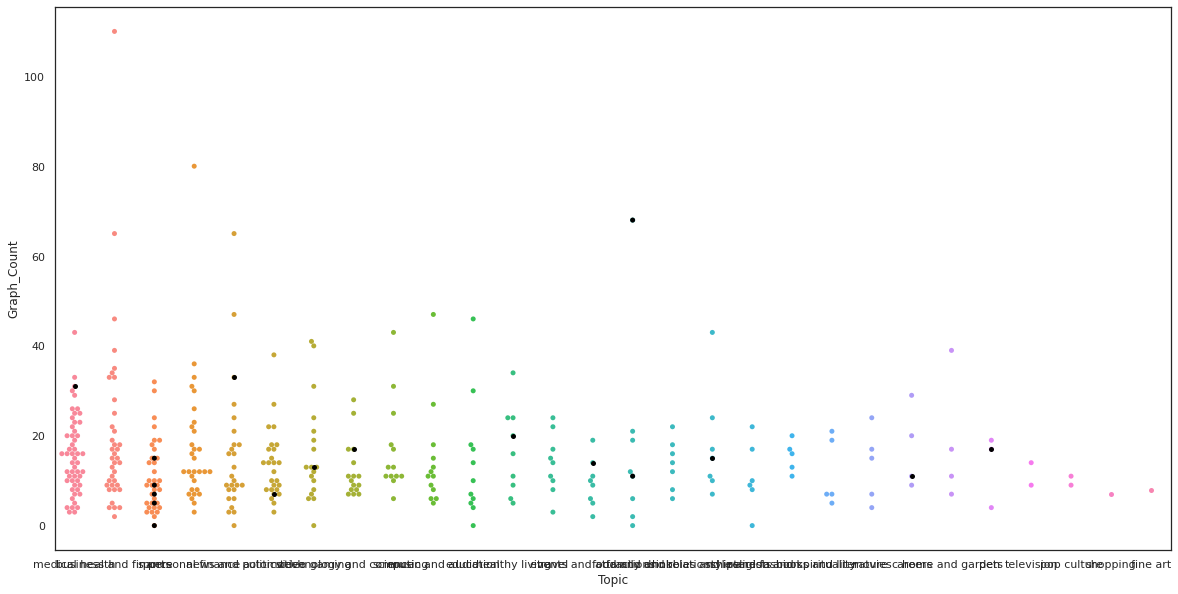

In [24]:
sns.swarmplot(x='Topic', y='Graph_Count', data=df, order=df['Topic'].value_counts().index)
sns.swarmplot(x='Topic', y='Graph_Count', data=df[df['Special']==True], order=df['Topic'].value_counts().index, color='black')

In [15]:
outcome, predictors = patsy.dmatrices('Word_Count ~ Special', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             Word_Count   R-squared:                       0.048
Model:                            OLS   Adj. R-squared:                  0.045
Method:                 Least Squares   F-statistic:                     18.17
Date:                Wed, 01 Dec 2021   Prob (F-statistic):           2.58e-05
Time:                        13:07:49   Log-Likelihood:                -3180.3
No. Observations:                 364   AIC:                             6365.
Df Residuals:                     362   BIC:                             6372.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept        3805.2190     81.148     46.892      0.000    3645.638    3964.800
Special[T.True]  1600.6633    375.496      4.263      0.000     862.235    2339.092
==============================================================================
Omnibus:                       60.523   Durbin-Watson:                   1.787
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               90.218
Skew:                           1.053   Prob(JB):                     2.57e-20
Kurtosis:                       4.231   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [36]:
outcome, predictors = patsy.dmatrices('Table_Count ~ Special', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Table_Count   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.9060
Date:                Wed, 01 Dec 2021   Prob (F-statistic):              0.342
Time:                        12:37:06   Log-Likelihood:                -1379.7
No. Observations:                 364   AIC:                             2763.
Df Residuals:                     362   BIC:                             2771.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          10.8127      0.577     18.748      0.000       9.679      11.947
Special[T.True]     2.5403      2.669      0.952      0.342      -2.708       7.788
==============================================================================
Omnibus:                      201.754   Durbin-Watson:                   1.672
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1273.343
Skew:                           2.335   Prob(JB):                    3.14e-277
Kurtosis:                      10.884   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [37]:
outcome, predictors = patsy.dmatrices('Graph_Count ~ Special', df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            Graph_Count   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.4824
Date:                Wed, 01 Dec 2021   Prob (F-statistic):              0.488
Time:                        12:37:13   Log-Likelihood:                -1418.1
No. Observations:                 364   AIC:                             2840.
Df Residuals:                     362   BIC:                             2848.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          15.1758      0.641     23.683      0.000      13.916      16.436
Special[T.True]     2.0595      2.965      0.695      0.488      -3.772       7.891
==============================================================================
Omnibus:                      260.694   Durbin-Watson:                   1.998
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3704.822
Skew:                           2.871   Prob(JB):                         0.00
Kurtosis:                      17.536   Cond. No.                         4.75
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Ethics & Privacy

The projects we analyzed were publicly available on github and to our knowledge the projects are only public if the students explicitly agree for the projects to be public. If a student of a project dissents to its analysis due to perhaps not forseeing the possibility that their project would be looked at, then they probably should not have agreed to make it public in the first place. As for the students' privacy, the names of the students were available on every project we analyzed. However, we only scraped the projects of its word count, topics, etc. and never touched or used the names for anything in our research. Our project not once mentions these names or calls attention to certain individuals or projects. So while there is room for privacy concerns regarding usage of names, we do not make the identities any less private than they already are. 

The biggest concern with bias in our analysis rests on the API we used for deciding topics after parsing the introductory paragraphs. It could classify up to 560 suprisingly specific topics, but there are obviously much more topics in existence. So we lose a lot of nuance with what the topic of the project is during analysis. We lose even more nuance when you consider that if for example a project topic is car racing, it could be read by the API to be about automobiles if the paragraph's contents is 60% cars and 40% sports, completely cutting out how the topic is 40% about sports and therefore treated equally as a topic that is about trucks. We originally accounted for this by switching from an initial API to the much better and more specific API we currently use, but beyond that there is not much more we can realistically do beyond checking the hundreds of projects by hand as API's are not at a human level of nuance yet. The best we can do is acknowledge that any analysis is not set in stone as some topic trends may be inflated by unique but somewhat similar topics. At the same time, analysis of trends in topics would be impossible if we actually managed to divide every single project into its own unqiue topic, as there would be no connection between projects, so we have to analyze by the large broad topics anyways. Tradeoffs.

# Conclusion & Discussion

*Fill in your discussion information here*

# Team Contributions

*Specify who in your group worked on which parts of the project.*